- Plan to train each column separately.
- Here, use an rnn model to train the first column: `toxic`

In [1]:
## system
import os

## Math and dataFrame
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import csr_matrix, hstack

## Visualization
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns

/Users/saizhang/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
## Traditional Machine Learning
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer

In [3]:
## Keras
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping#, TensorBoard
from keras import backend as K
from keras import optimizers
from keras.optimizers import SGD
from keras import initializers
from keras.callbacks import LearningRateScheduler
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


Load data

In [4]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

Do some statistics first

In [5]:
display(train[:10])
print(train.shape)
print("toxic count = {0}".format(train.toxic.sum()))
print("severe_toxic count = {0}".format(train.severe_toxic.sum()))
print("obscene count = {0}".format(train.obscene.sum()))
print("threat count = {0}".format(train.threat.sum()))
print("insult count = {0}".format(train.insult.sum()))
print("identity_hate count = {0}".format(train.identity_hate.sum()))

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


(159571, 8)
toxic count = 15294
severe_toxic count = 1595
obscene count = 8449
threat count = 478
insult count = 7877
identity_hate count = 1405


Show correlation

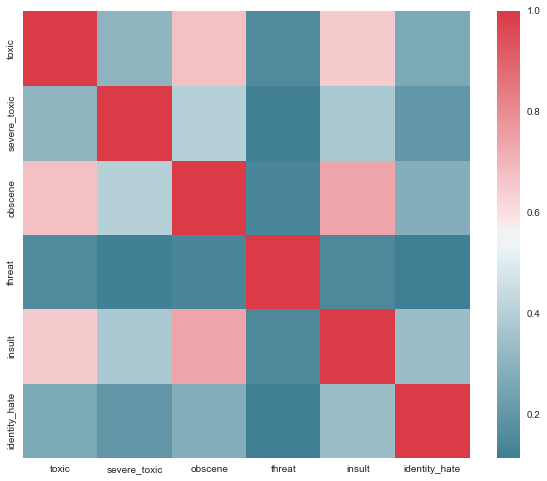

In [6]:
corr = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

For Sentence processing

###### 自己电脑上run 不了nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
stop = set(stopwords.words('english'))
punc = set(string.punctuation)

In [7]:
#PROCESS TEXT: RAW
print("Text to seq process...")
print("   Fitting tokenizer...")
from keras.preprocessing.text import Tokenizer
raw_text = np.hstack([train.comment_text.str.lower(), 
                      test.comment_text.str.lower()])
tok_raw = Tokenizer()
tok_raw.fit_on_texts(raw_text)
print("   Transforming text to seq...")
train["input"] = tok_raw.texts_to_sequences(train.comment_text.str.lower())
test["input"] = tok_raw.texts_to_sequences(test.comment_text.str.lower())

Text to seq process...
   Fitting tokenizer...
   Transforming text to seq...


Do some statistics on sentence length

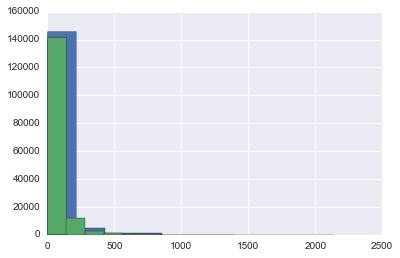

In [8]:
test.input.apply(lambda x: len(x)).hist()
train.input.apply(lambda x: len(x)).hist()

In [9]:
MAX_LENGTH = 450
MAX_TOKEN = np.max([np.max(train.input.max()),np.max(test.input.max())]) + 5
print(MAX_LENGTH, MAX_TOKEN)

(450, 395455)


Here we only train toxic

In [10]:
train = train[['input', 'toxic']]
dtrain, dvalid = train_test_split(train, random_state=17, train_size=0.7)
print(dtrain.shape)
print(dvalid.shape)

(111699, 2)
(47872, 2)


Using the most stupid way to balancerize the classes

In [11]:
L = len(dtrain)
df_irr = dtrain[dtrain.toxic != 0]
while len(dtrain) < 2*L:
    dtrain = dtrain.append(df_irr, ignore_index=True)

In [12]:
L = len(dvalid)
df_irr = dvalid[dvalid.toxic != 0]
while len(dvalid) < 2*L:
    dvalid = dvalid.append(df_irr, ignore_index=True)

In [13]:
display(dtrain[:10])
display(dvalid[:10])

,input,toxic
0,"[74, 240, 2521, 6, 356, 30, 601, 35, 1, 4093, ...",1
1,"[3631, 243, 42, 5584, 628, 17, 1, 6131, 176, 3...",0
2,"[463, 95, 12, 7790, 73, 49, 31, 5, 24026, 335,...",0
3,"[7, 229, 12442, 30, 206, 31066, 8, 1400, 5, 1,...",0
4,"[1742, 25, 182, 5583, 3, 297, 94341, 12403, 24...",0
5,"[95, 12, 1, 1274, 639, 8958, 7, 24, 371, 5065,...",0
6,"[1536, 5, 1544, 22, 6, 403, 154, 2, 16, 4, 424...",0
7,"[422, 15001, 7, 81, 165, 2, 34, 4, 738, 79, 3,...",0
8,"[50, 59, 82, 8570, 25637, 17, 4, 120, 50, 59, ...",0
9,"[6, 476, 108, 2, 156, 127, 30, 242, 751, 1, 25...",0


,input,toxic
0,"[2893, 2244, 99, 183, 98, 2893, 33, 20, 3573, ...",0
1,"[583, 203309, 98, 2, 70, 1813, 3, 2469, 18, 27...",0
2,"[1, 4214, 9615, 579, 2, 188814, 1153, 401, 15,...",0
3,"[437, 3, 40, 164, 14, 203, 4496, 2, 38, 72, 35...",0
4,"[1122, 7, 1227, 6, 1424, 25237]",0
5,"[62, 167, 1, 4327, 3, 946, 8, 15, 37, 7, 237, ...",0
6,"[6, 184, 108, 2, 159, 4, 147, 33, 13, 28, 83, ...",0
7,"[760, 12, 325, 301]",1
8,"[134, 6, 12, 1811, 21, 1, 29, 2228, 6419, 15, ...",0
9,"[22346, 5, 1545, 4650, 178, 41, 280, 12, 1, 79...",0


Create input for train and validation

In [14]:
train_x = pad_sequences(dtrain.input, maxlen=MAX_LENGTH)
valid_x = pad_sequences(dvalid.input, maxlen=MAX_LENGTH)

Create one hot output for train and validation

In [15]:
train_y = np_utils.to_categorical(dtrain.toxic.values, 2)
valid_y = np_utils.to_categorical(dvalid.toxic.values, 2)

Creating models: most simple RNN

In [16]:
A = Input(shape=[MAX_LENGTH], name="in")
B = Embedding(MAX_TOKEN, 128)(A)
C = GRU(32) (B)
D = Dropout(0.6) (Dense(128, activation='relu') (C))
E = Dropout(0.4) (Dense(32, activation='relu') (D))
output = Dense(2, activation="softmax") (E)

In [17]:
model = Model(A, output)
N_epoch = 1
learning_rate = 0.05
optimizer = SGD(learning_rate)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in (InputLayer)              (None, 450)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 450, 128)          50618240  
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                15456     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4224      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
__________

Start Trainning

In [18]:
res = model.fit(train_x, train_y, batch_size = 128, epochs = N_epoch, 
                verbose = 1, validation_data = (valid_x, valid_y))

Train on 229509 samples, validate on 98296 samples
Epoch 1/1
229509/229509 [==============================] - 1525s 7ms/step - loss: 0.6226 - acc: 0.6339 - val_loss: 1.6916 - val_acc: 0.5624
